In this notebook, we are going to load some of the data that we processed in the Condensed Notebook and perform across-trial analysis of the power spectra using FOOOF, an iterative peak-detection and PSD 1/f fitting algorithm. 

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import mne
import mne_connectivity
import pactools
from mne_connectivity import phase_slope_index, seed_target_indices, spectral_connectivity_epochs
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import fooof
# Import plotting functions
from fooof.plts.spectra import plot_spectrum, plot_spectra
# Import the FOOOF object
from fooof import FOOOF
from fooof import FOOOFGroup
import os 
import joblib
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pickle
from tqdm import tqdm
from IPython.display import clear_output
import warnings 

# I only want to see warnings once
warnings.filterwarnings('ignore')

from joblib import delayed, Parallel
from statsmodels.stats import multitest

Note: If you have installed this package in editable form on Minerva, you must append the local path! This is because Minerva requires that you point your package installs away from the local directory for space reasons, but editable packages have to be installed locally.

In [4]:
import sys
sys.path.append('/hpc/users/qasims01/resources/LFPAnalysis')

In [5]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils, oscillation_utils, statistics_utils


Before running the following, you need to: 

1. Load relevant behavioral data produced from your proprietary behavioral analyses.
1. Load neural epochs of behavioral interest produced from the Condensed Notebook.

## First, get the behavior data

This is from another notebook with a kernel and environment specifically for beahvior

In [6]:
base_dir = '/sc/arion' # this is the root directory for most un-archived data and results
load_dir = f'{base_dir}/work/qasims01/MemoryBanditData/EMU'

# Load the demographics data to get information about who has run the task
demo_file = f'{base_dir}/projects/guLab/Salman/EMU/MemoryBanditsDatabase.xlsx'
demo_data = pd.read_excel(demo_file, engine='openpyxl')
subj_df = demo_data[(demo_data.LongVersion==1) & (demo_data.Minerva==1)]

# Let's get rid of Iowa patients for now 

subj_df = subj_df[subj_df.Site!='UI']

days = ['Day1', 'Day2']
subj_ids = subj_df.MSSMCode.values
subj_formats = subj_df.format.values
subj_sites = subj_df.Site.values
subj_days = subj_df.Day2.values

In [7]:
# load behavioral data
learn_df = pd.read_csv(f'{load_dir}/learn_df.csv')
combined_df = pd.read_csv(f'{load_dir}/combined_df.csv')

# Filter just to the participants in this notebook
learn_df = learn_df[learn_df.participant.isin(subj_ids)]
combined_df = combined_df[combined_df.participant.isin(subj_ids)]


# I enter the day information in stupidly 
combined_df.condition = combined_df.condition.apply(lambda x: 'Day1' if x=='day_1' else 'Day2' if x=='day_2' else np.nan)
combined_df['recog_time'] = combined_df['recog_time'].apply(lambda x: float(x) if (~pd.isna(x)) & (x!='None') else x)
combined_df['baseline_start_mem'] = combined_df['baseline_start_mem'].apply(lambda x: float(x) if (~pd.isna(x)) & (x!='None') else x)

# add RPE to the combined df dataframe: 

combined_df['rpe'] = np.nan
for ix, row in learn_df.iterrows():
    combined_df.loc[(combined_df.img_path==row.img_path) & (combined_df.participant==row.participant), 'rpe'] = row.rpe

## Power spectrum (FOOOF)

Here, we are going to plot the group-level FOOOF analysis for two conditions in the task across all channels, and then also plot the individual power spectrums for each channel with model fit for each of the two conditions. Note the time specification to make sure I leave out the baseline period... 

FOOOF's primary utility, imo, is not in peak parameterization but 1/f subtraction. Peak parameters are subject to over- and under-fitting, and fit quality has too strong of an effect. Simply contrasting *n* PSDs (for *n* conditions) after removing the 1/f is a more healthy approach imo.

For guidance on picking the parameters used to fit: https://fooof-tools.github.io/fooof/auto_tutorials/plot_07-TroubleShooting.html#sphx-glr-auto-tutorials-plot-07-troubleshooting-py

## 1. FOOOF (produce dataframe and condition-specific plots)

In [42]:
%%time
ev_dict = {'feedback_start': [0, 1.5]}

# Define peak_width, peak_height, peak_threshold, max_n_peaks
FOOOF_kwargs = {'peak_width_limits': [1, 8], 
               'min_peak_height': 0.1,
                'peak_threshold': 1.,
                'max_n_peaks': 3,
               'freq_range': [1, 30]}
 
# Define our frequency bands of interest
band_dict = {'delta' : [1, 4],
               'theta' : [4, 8],
               'alpha' : [8, 13],
               'beta' : [13, 30]}

conditions = ['rpe>0',
             'rpe<1']

progress_bar = tqdm(subj_ids, ascii=True, desc='Computing FOOOF for all trials and subsetting by conditions')

for subj_id in progress_bar:
    # Load one person's data 
    for day in ['Day1']:
        load_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'
        for event in ev_dict.keys():   
            filepath = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/scratch/FOOOF/{event}'
            if not os.path.exists(f'{filepath}/plots'):
                os.makedirs(f'{filepath}/plots')
            if not os.path.exists(f'{filepath}/dfs'):
                os.makedirs(f'{filepath}/dfs')

            mne_data_reref = mne.read_epochs(f'{load_path}/{event}-epo.fif', preload=True)
            mne_data_reref.metadata = learn_df[learn_df.participant==subj_id]

            save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}'
            # Get electrode df 
            elec_df = pd.read_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/{day}_reref_elec_df')
            
            # # Run the FOOOF code in parallel
            Parallel(n_jobs=-1, verbose=1)(delayed(analysis_utils.compute_FOOOF_parallel)(chan, mne_data_reref, 
                                                                                         subj_id, 
                                                                                         elec_df, 
                                                                                         event, 
                                                                                         ev_dict, 
                                                                                         band_dict, 
                                                                                         conditions, 
                                                                                         do_plot=True, 
                                                                                         save_path='/sc/arion/projects/guLab/Salman/EphysAnalyses',
                                                                                         do_save=True, 
                                                                                         **FOOOF_kwargs) for chan in mne_data_reref.ch_names)


Computing FOOOF for all trials and subsetting by conditions:   0%|          | 0/16 [00:00<?, ?it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 83 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:   46.4s finished
Computing FOOOF for all trials and subsetting by conditions:   6%|6         | 1/16 [00:46<11:38, 46.59s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS015/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 64 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    1.9s finished
Computing FOOOF for all trials and subsetting by conditions:  12%|#2        | 2/16 [00:48<04:46, 20.44s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS016/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 92 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 out of  92 | elapsed:    3.2s finished
Computing FOOOF for all trials and subsetting by conditions:  19%|#8        | 3/16 [00:52<02:45, 12.72s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS017/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 85 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:    3.0s finished
Computing FOOOF for all trials and subsetting by conditions:  25%|##5       | 4/16 [00:55<01:48,  9.03s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS019/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 116 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:    4.6s finished
Computing FOOOF for all trials and subsetting by conditions:  31%|###1      | 5/16 [01:00<01:23,  7.57s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS020/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 110 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    4.2s finished
Computing FOOOF for all trials and subsetting by conditions:  38%|###7      | 6/16 [01:05<01:05,  6.54s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS022/neural/Day1/feedback_start-epo.fif ...
    Reading extended channel information
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 52 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 out of  52 | elapsed:    1.6s finished
Computing FOOOF for all trials and subsetting by conditions:  44%|####3     | 7/16 [01:07<00:47,  5.33s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS023/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 120 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.9s finished
Computing FOOOF for all trials and subsetting by conditions:  50%|#####     | 8/16 [01:13<00:42,  5.31s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS024/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 116 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:    4.3s finished
Computing FOOOF for all trials and subsetting by conditions:  56%|#####6    | 9/16 [01:17<00:35,  5.09s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS025/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 133 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-1)]: Done 133 out of 133 | elapsed:    6.1s finished
Computing FOOOF for all trials and subsetting by conditions:  62%|######2   | 10/16 [01:24<00:33,  5.54s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS026/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 126 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    5.3s finished
Computing FOOOF for all trials and subsetting by conditions:  69%|######8   | 11/16 [01:30<00:27,  5.59s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS028/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 132 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    5.9s finished
Computing FOOOF for all trials and subsetting by conditions:  75%|#######5  | 12/16 [01:36<00:23,  5.81s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS030/neural/Day1/feedback_start-epo.fif ...
    Reading extended channel information
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 105 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:    5.9s finished
Computing FOOOF for all trials and subsetting by conditions:  81%|########1 | 13/16 [01:42<00:17,  5.93s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS034/neural/Day1/feedback_start-epo.fif ...
    Reading extended channel information
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 139 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-1)]: Done 139 out of 139 | elapsed:    6.4s finished
Computing FOOOF for all trials and subsetting by conditions:  88%|########7 | 14/16 [01:49<00:12,  6.19s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS035/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 151 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-1)]: Done 151 out of 151 | elapsed:    7.1s finished
Computing FOOOF for all trials and subsetting by conditions:  94%|#########3| 15/16 [01:56<00:06,  6.60s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS036/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 126 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    5.4s finished
Computing FOOOF for all trials and subsetting by conditions: 100%|##########| 16/16 [02:02<00:00,  7.67s/it]

CPU times: user 11.3 s, sys: 3.75 s, total: 15 s
Wall time: 2min 2s


With 25 cores, this took ~0.5 second / electrode

In [43]:
# Load the dataframes: 
chan_dfs = [] 
for subj_id in subj_ids:
    for day in ['Day1']:
        load_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'
        for event in ev_dict.keys():   
            filepath = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/scratch/FOOOF/{event}'
            elec_df = pd.read_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/{day}_reref_elec_df')
            for chan in tqdm(elec_df.label.unique(), ascii=True, desc='Loading FOOOF dataframes'): 
                chan_df = pd.read_csv(f'{filepath}/dfs/{chan}_df.csv')
                chan_dfs.append(chan_df)
chan_dfs = pd.concat(chan_dfs)

Loading FOOOF dataframes: 100%|##########| 126/126 [00:00<00:00, 131.53it/s]


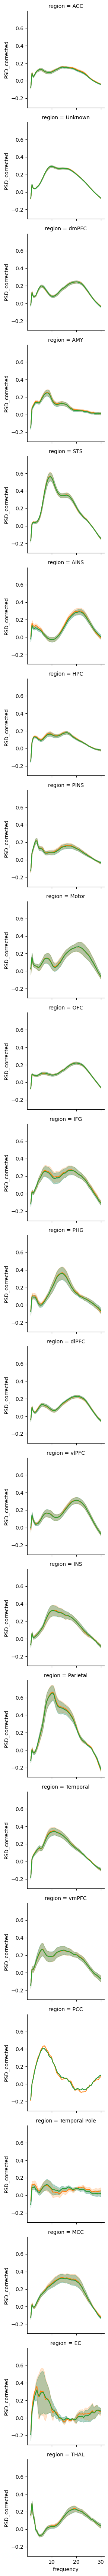

In [47]:
g = sns.FacetGrid(chan_dfs, row="region", hue='cond')
g.map(sns.lineplot, "frequency", "PSD_corrected",  errorbar='se')



In [48]:
grouped_df = chan_dfs.groupby(['region', 'channel', 'cond', 'in_FOOOF_peak']).mean().reset_index().drop(columns=['in_FOOOF_peak', 'frequency', 'PSD_raw'])


                                                                                 
                                                                                 

In [49]:
grouped_df[grouped_df.peak_freq!=0]

,region,channel,cond,PSD_corrected,peak_freq,peak_height,PSD_exp
1,ACC,lacam1-lacam2,all,0.192104,3.844139,0.215071,1.766096
2,ACC,lacam1-lacam2,all,0.269256,15.856015,0.293497,1.766096
3,ACC,lacam1-lacam2,all,0.144445,21.099806,0.134807,1.766096
5,ACC,lacam1-lacam2,rpe<1,0.192104,3.844139,0.215071,1.766096
6,ACC,lacam1-lacam2,rpe<1,0.269256,15.856015,0.293497,1.766096
...,...,...,...,...,...,...,...
10013,vmPFC,rmoif2-rmoif3,rpe<1,0.555005,14.769243,0.589678,1.279201
10014,vmPFC,rmoif2-rmoif3,rpe<1,0.399347,20.387378,0.377183,1.279201
10016,vmPFC,rmoif2-rmoif3,rpe>0,0.253865,6.044580,0.265918,1.224281
10017,vmPFC,rmoif2-rmoif3,rpe>0,0.536915,14.268380,0.574685,1.224281


In [153]:
# # Fit an individual channel (for plotting)
# ind_fits = FOOOFGroup_res.get_fooof(ind=0, regenerate=True)
# ind_fits.fit()

In [154]:
# ind_fits.plot()